In [1]:
from model_PyG import *
from utils import *

/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  import torch_geometric.typing
/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  import torch_geometric.typing
/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /home/ealva

In [2]:
import matplotlib.pyplot as plt
import torch
# import torch.nn.functional as F
import torch_geometric.transforms as T

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.transforms import Compose
from torch_geometric.utils import dense_to_sparse, negative_sampling
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.optim import Adam

In [3]:
import torch_geometric
print(torch_geometric.__version__)

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

2.7.0


In [4]:
def info(data):
	print("Validate:\t {}".format(data.validate(raise_on_error=True)))
	print("Num. nodes:\t {}".format(data.num_nodes))
	print("Num. edges:\t {}".format(data.num_edges))
	print("Num. features:\t {}".format(data.num_node_features))
	print("Has isolated:\t {}".format(data.has_isolated_nodes()))
	print("Has loops:\t {}".format(data.has_self_loops()))
	print("Is directed:\t {}".format(data.is_directed()))
	print("Is undirected:\t {}".format(data.is_undirected()))
	print("{}".format(data.edge_index))
	print("{}".format(data.x))
	print("{}".format(data.edge_weight))

### Setup

In [5]:
dataset = "ACM_DBLP" # "Douban Online_Offline", "ACM_DBLP" # args.dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if (dataset == "ACM_DBLP"):
	train_set = ["ACM", "DBLP"]
	b = np.load("data/ACM-DBLP.npz")
	# train_features["ACM"] = [torch.from_numpy(b["x1"]).float()]
	# train_features["DBLP"] = [torch.from_numpy(b["x2"]).float()]
	test_pairs = b["test_pairs"].astype(np.int32)
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	# input_dim = 17
	output_feature_size = 128
	lr = 1e-4 # 1e-4
	epochs = 100
elif (dataset == "Douban Online_Offline"):
	train_set = ["Online", "Offline"]
	a1, f1, a2, f2, test_pairs = load_douban()
	# f1 = f1.A
	# f2 = f2.A
	test_pairs = torch.tensor(np.array(test_pairs, dtype=int)) - 1
	test_pairs = test_pairs.numpy()
	# train_features["Online"] = [torch.from_numpy(f1).float()]
	# train_features["Offline"] = [torch.from_numpy(f2).float()]
	NUM_HIDDEN_LAYERS = 6
	HIDDEN_DIM = [512, 512, 512, 512, 512, 512, 512]
	# input_dim = 538
	output_feature_size = 512
	lr = 0.0001
	epochs = 100

### Understand Data (PyG)

#### Data (PyG)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3]], dtype=torch.long)
x = torch.tensor([[0, 1], [1, 2], [2, 3], [3, 4]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0, 1.5], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3]], dtype=torch.long)
x = torch.tensor([
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0, 1.5], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

data = transform(data)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 0],
	[1, 2],
	[2, 1]], dtype=torch.long)
x = torch.tensor([
    [0, 1], 
    [1, 2], 
    [2, 3]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 0.5, 1.0, 1.0], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

info(data)
transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

data = transform(data)

info(data)

#### Data ACM_DBLP

In [ ]:
train_set

In [ ]:
b.files

In [ ]:
edge_index1 = b["edge_index1"]
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2 = b["edge_index2"]
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = b["x1"]
print(x1.shape)
x1

In [ ]:
x2 = b["x2"]
print(x2.shape)
x2

In [ ]:
test_pairs

#### Data Douban Online_Offline

In [ ]:
train_set

In [ ]:
a1, f1, a2, f2, test_pairs = load_douban()

In [ ]:
torch.from_numpy(a1.toarray())

In [ ]:
torch.from_numpy(a2.toarray())

In [ ]:
torch.from_numpy(f1.toarray())

In [ ]:
torch.from_numpy(f2.toarray())

In [ ]:
edge_index1, edge_attr1 = dense_to_sparse(torch.from_numpy(a1.toarray()))
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2, edge_attr2 = dense_to_sparse(torch.from_numpy(a2.toarray()))
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = torch.from_numpy(f1.toarray()).float()
print(x1.shape)
x1

In [ ]:
x2 = torch.from_numpy(f2.toarray()).float()
print(x2.shape)
x2

In [ ]:
test_pairs

### Create Data (PyG)

In [6]:
transform = Compose([
	# T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

In [7]:
train_set

['ACM', 'DBLP']

In [8]:
print("Loading training datasets")

train_loader = {}
# scaler = StandardScaler()

if dataset == "ACM_DBLP":
	for i, ts in enumerate(train_set):
		edge_index = torch.tensor(b[f"edge_index{i+1}"], dtype=torch.long)
		x = torch.tensor(b[f"x{i+1}"], dtype=torch.float)
		# x = torch.tensor(scaler.fit_transform(x.numpy())) # scaling
		data = Data(x=x, edge_index=edge_index)
		data = transform(data)
		info(data)
		train_loader[ts] = data
elif dataset == "Douban Online_Offline":
	edge_index1, _= dense_to_sparse(torch.from_numpy(a1.toarray()))
	x1 = torch.from_numpy(f1.toarray()).float()
	data1 = Data(x=x1, edge_index=edge_index1)
	data1 = transform(data1)
	info(data1)
	train_loader[train_set[0]] = data1

	edge_index2, _= dense_to_sparse(torch.from_numpy(a2.toarray()))
	x2 = torch.from_numpy(f2.toarray()).float()
	data2 = Data(x=x2, edge_index=edge_index2)
	data2 = transform(data2)
	info(data2)
	train_loader[train_set[1]] = data2

Loading training datasets
Validate:	 True
Num. nodes:	 9872
Num. edges:	 88994
Num. features:	 17
Has isolated:	 False
Has loops:	 True
Is directed:	 False
Is undirected:	 True
tensor([[   0,    0,    0,  ..., 9869, 9870, 9871],
        [   1,    2,    3,  ..., 9869, 9870, 9871]], device='cuda:0')
tensor([[61., 42., 16.,  ..., 14.,  1., 22.],
        [54., 18., 12.,  ..., 11.,  0., 16.],
        [54., 61.,  9.,  ..., 10.,  0., 39.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  1.]], device='cuda:0')
None
Validate:	 True
Num. nodes:	 9916
Num. edges:	 99532
Num. features:	 17
Has isolated:	 False
Has loops:	 True
Is directed:	 False
Is undirected:	 True
tensor([[   0,    0,    0,  ..., 9913, 9914, 9915],
        [ 450, 4031, 4447,  ..., 9913, 9914, 9915]], device='cuda:0')
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0

In [9]:
train_loader

{'ACM': Data(x=[9872, 17], edge_index=[2, 88994]),
 'DBLP': Data(x=[9916, 17], edge_index=[2, 99532])}

### Train

In [10]:
def compute_num_neg_samples(edge_index, num_nodes, ratio):
	E = edge_index.size(1)
	max_neg = num_nodes * num_nodes - E
	return min(int(ratio * E), max_neg)

def neg_ratio_schedule(epoch, max_epoch):
	start = 5.0
	end = 1.0
	return start - (start - end) * (epoch / max_epoch)

class EarlyStopping:
	def __init__(self, patience=5, delta=0, warmup=5, verbose=False):
		self.patience = patience
		self.delta = delta
		self.warmup = warmup
		self.verbose = verbose
		self.best_loss = None
		self.no_improvement_count = 0
		self.stop_training = False
	
	def check_early_stop(self, loss, epoch):
		if epoch >= self.warmup:
			if self.best_loss is None or loss < self.best_loss - self.delta:
				self.best_loss = loss
				self.no_improvement_count = 0
			else:
				self.no_improvement_count += 1
				if self.no_improvement_count >= self.patience:
					self.stop_training = True
					if self.verbose:
						print("Stopping early as no improvement has been observed.")

In [11]:
def fit_TGAE_subgraph(dataset, no_samples, model, epochs, train_loader, lr, test_pairs):
	best_hitAtOne = 0
	best_hitAtFive = 0
	best_hitAtTen = 0
	best_hitAtFifty = 0
	list_loss = []

	optimizer = Adam(model.parameters(), lr=lr,weight_decay=5e-4)
	
	# Initialize early stopping
	patience = 10
	delta = 1e-4
	warmup = 10
	early_stopping = EarlyStopping(patience=patience, delta=delta, warmup=warmup, verbose=True)

	loop_obj = tqdm(range(1, epochs + 1))
	for epoch in loop_obj:
		loop_obj.set_description(f"Epoch: {epoch}")
		
		# Train
		model.train()
		loss = 0.0
		
		for _, data_obj in train_loader.items():
			x = data_obj.x
			edge_index = data_obj.edge_index
			
			# Encoder
			z = model(x, edge_index)
			# z = F.normalize(z, dim=1)

			# Positive edges
			pos_edge_index = edge_index
			
			# Negative edges
			# option 1
			neg_edge_index = negative_sampling(
				edge_index=edge_index,
				num_nodes=z.size(0),
				num_neg_samples=pos_edge_index.size(1), # Change 2 to other value if needed
				method="sparse"
			)
			# Negative edges (dynamic)
			# option 2
			""" ratio = neg_ratio_schedule(epoch, epochs)
			num_neg = compute_num_neg_samples(
				edge_index=edge_index,
				num_nodes=z.size(0),
				ratio=ratio
			)
			neg_edge_index = negative_sampling(
				edge_index=edge_index,
				num_nodes=z.size(0),
				num_neg_samples=num_neg,
				method="sparse"
			) """
			
			# Decoder
			pos_logits = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
			neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)

			pos_labels = torch.ones_like(pos_logits)
			neg_labels = torch.zeros_like(neg_logits)

			# Loss
			loss_pos = binary_cross_entropy_with_logits(pos_logits, pos_labels)
			loss_neg = binary_cross_entropy_with_logits(neg_logits, neg_labels)

			loss += loss_pos + loss_neg
			
		optimizer.zero_grad()
		loss = loss / no_samples
		loss.backward()
		optimizer.step()

		loop_obj.set_postfix_str(f"Loss: {loss.item():.4f}")
		list_loss.append(loss.item())

		# Evaluation
		model.eval()
		with torch.no_grad():
			keys = list(train_loader.keys())
			data1 = train_loader[keys[0]]
			data2 = train_loader[keys[1]]

			z1 = model(data1.x, data1.edge_index).detach()
			z2 = model(data2.x, data2.edge_index).detach()

			# z1 = F.normalize(z1, dim=1)
			# z2 = F.normalize(z2, dim=1)
			
			D = torch.cdist(z1, z2, 2)
			
			if dataset == "ACM_DBLP":
				test_idx = test_pairs[:, 0].astype(int)
				labels = test_pairs[:, 1].astype(int)
			else:
				test_idx = test_pairs[0, :].astype(int)
				labels = test_pairs[1, :].astype(int)
				
			hitAtOne = 0
			hitAtFive = 0
			hitAtTen = 0
			hitAtFifty = 0
			hitAtHundred = 0
			for i in range(len(test_idx)):
				dist_list = D[test_idx[i]]
				sorted_neighbors = torch.argsort(dist_list).cpu()
				label = labels[i]
				for j in range(100):
					if (sorted_neighbors[j].item() == label):
						if (j == 0):
							hitAtOne += 1
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 4):
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 9):
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 49):
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 100):
							hitAtHundred += 1
							break
			cur_hitAtOne = hitAtOne / len(test_idx)
			cur_hitAtFive = hitAtFive / len(test_idx)
			cur_hitAtTen = hitAtTen / len(test_idx)
			cur_hitAtFifty = hitAtFifty / len(test_idx)

			if(cur_hitAtOne > best_hitAtOne): best_hitAtOne = cur_hitAtOne
			if (cur_hitAtFive > best_hitAtFive): best_hitAtFive = cur_hitAtFive
			if (cur_hitAtTen > best_hitAtTen): best_hitAtTen = cur_hitAtTen
			if (cur_hitAtFifty > best_hitAtFifty): best_hitAtFifty = cur_hitAtFifty

		# Check early stopping condition
		early_stopping.check_early_stop(loss.item(), epoch)
		if early_stopping.stop_training:
			print(f"Early stopping at epoch {epoch}")
			break

	print("The best results achieved:")
	print("Hit@1: ", end="")
	print(best_hitAtOne)
	print("Hit@5: ", end="")
	print(best_hitAtFive)
	print("Hit@10: ", end="")
	print(best_hitAtTen)
	print("Hit@50: ", end="")
	print(best_hitAtFifty)

	torch.cuda.empty_cache()

	return [z1, z2], list_loss

In [12]:
no_samples = len(train_set) # * (1 + 1)  # num datasets * num of samples by dataset 
input_dim = train_loader[train_set[0]].num_node_features

model = TGAE(NUM_HIDDEN_LAYERS,
			input_dim,
			HIDDEN_DIM,
			output_feature_size).to(device)

print("Generating training features")
print("Fitting model")
print(dataset, lr, epochs, input_dim, output_feature_size, no_samples)

list_z, list_loss = fit_TGAE_subgraph(dataset, no_samples, model, epochs, train_loader, lr,test_pairs)

Generating training features
Fitting model
ACM_DBLP 0.0001 100 17 128 2


Epoch: 100: 100%|██████████| 100/100 [02:51<00:00,  1.71s/it, Loss: 0.8207]

The best results achieved:
Hit@1: 0.7154150197628458
Hit@5: 0.8930830039525691
Hit@10: 0.9351778656126483
Hit@50: 0.9689723320158102


### Plot

In [13]:
# Concatenate embeddings
z_cat = torch.cat(list_z, dim=0).cpu().numpy()
print(z_cat.shape)
z_cat

(19788, 128)


array([[-0.548473  , -1.9065415 , -0.12657052, ...,  0.8694002 ,
        -0.01292948,  0.47337008],
       [-0.8172968 , -1.3075217 ,  0.02710791, ..., -0.01031893,
        -1.0235926 ,  0.37516287],
       [-0.65648603, -3.0611262 , -0.09629162, ...,  0.76634824,
         0.7441154 ,  0.14829712],
       ...,
       [ 0.18406484,  0.07969693, -0.2534108 , ..., -0.19026431,
        -0.13765325, -0.20262167],
       [ 0.35625672,  0.0205626 ,  0.08364788, ...,  0.03185299,
        -0.02239448, -0.20017548],
       [ 0.1611462 ,  0.10323468, -0.23769267, ..., -0.19473702,
        -0.00799224,  0.1255927 ]], dtype=float32)

In [14]:
labels = np.array([
	i
	for i, z in enumerate(list_z)
	for _ in range(z.size(0))
])
print(labels.shape)
labels

(19788,)


array([0, 0, 0, ..., 1, 1, 1])

In [15]:
list_loss

[1.6446508169174194,
 19.819351196289062,
 1.7902554273605347,
 2.425987720489502,
 2.5928778648376465,
 1.352398157119751,
 1.1397995948791504,
 1.319469690322876,
 1.367113709449768,
 1.1545993089675903,
 1.051872968673706,
 1.0588469505310059,
 1.1040688753128052,
 1.1061134338378906,
 1.03727126121521,
 0.9840200543403625,
 0.9768635034561157,
 0.9921633005142212,
 1.006844401359558,
 0.9834800958633423,
 0.9524474143981934,
 0.9353868961334229,
 0.9330063462257385,
 0.9434255361557007,
 0.9413492679595947,
 0.9380382299423218,
 0.9240814447402954,
 0.9094176292419434,
 0.9008374810218811,
 0.9024229645729065,
 0.905310332775116,
 0.9055074453353882,
 0.8969913721084595,
 0.8872649073600769,
 0.8853520750999451,
 0.8822517395019531,
 0.880995512008667,
 0.8848645091056824,
 0.8787239789962769,
 0.8750631809234619,
 0.8727071285247803,
 0.8718218803405762,
 0.8690292239189148,
 0.8666671514511108,
 0.8679485321044922,
 0.862452507019043,
 0.8633570075035095,
 0.8590263724327087,
 0.

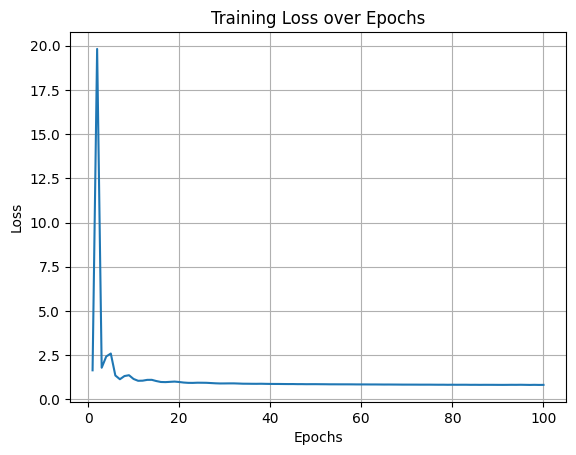

In [16]:
# Loss

plt.figure()
plt.plot(range(1, len(list_loss) + 1), list_loss) #, marker=".")
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

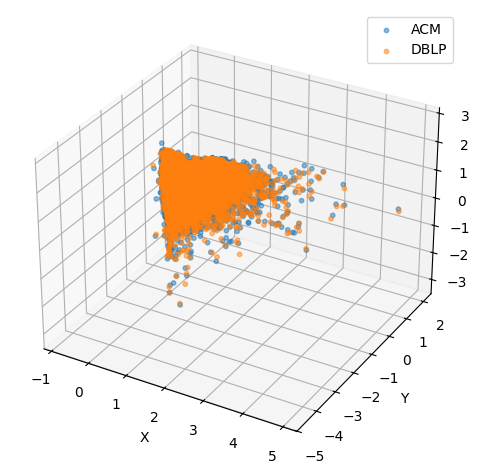

In [17]:
# Node embeddings 3D

if z_cat.shape[1] > 3:
	pca = PCA(n_components=3)
	z_cat_3d = pca.fit_transform(z_cat)
else:
	z_cat_3d = z_cat.copy()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for c in np.unique(labels):
	ax.scatter(
		z_cat_3d[:, 0][labels == c],
		z_cat_3d[:, 1][labels == c], 
		z_cat_3d[:, 2][labels == c],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()
plt.show()

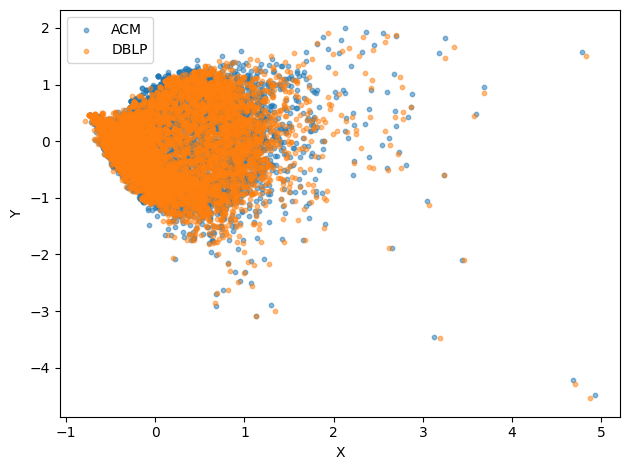

In [18]:
# Node embeddings 2D

if z_cat.shape[1] > 2:
	pca = PCA(n_components=2)
	z_cat_2d = pca.fit_transform(z_cat)
else:
	z_cat_2d = z_cat.copy()

fig, ax = plt.subplots()

for c in np.unique(labels):
	idx = labels == c
	ax.scatter(
		z_cat_2d[idx, 0],
		z_cat_2d[idx, 1],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()
plt.tight_layout()
plt.show()